# Лабораторная работа №3. Наивный байесовский классификатор

В рамках данной лабораторной работы предстоит реализовать наивный байесовский классификатор и сравнить его с эталонной реализацией из библиотеки `scikit-learn`.

## Задание

1. Выбрать датасет для анализа, например, на [kaggle](https://www.kaggle.com/datasets).
2. Реализовать наивный байесовский классификатор.
3. Обучить модель на выбранном датасете.
4. Оценить качество модели с использованием кросс-валидации.
5. Замерить время обучения модели.
6. Сравнить результаты с эталонной реализацией из библиотеки [scikit-learn](https://scikit-learn.org/stable/):
   * точность модели;
   * время обучения.
7. Подготовить отчет, включающий:
   * описание наивного байесовского классификатора;
   * описание датасета;
   * результаты экспериментов;
   * сравнение с эталонной реализацией;
   * выводы.

# 1. Выбрать датасет для анализа
### В качестве датасета был выбран набор данных для классификации лекарственных препаратов
### Таргет: Drug Type

### Ссылка:

https://www.kaggle.com/datasets/prathamtripathi/drug-classification

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prathamtripathi/drug-classification")

print("Path to dataset files:", path)

c:\Users\klimm\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\klimm\.cache\kagglehub\datasets\prathamtripathi\drug-classification\versions\1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('drug200.csv')

In [4]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


Пропусков нет - это хорошо, есть как численные, так и категориальные признаки

In [6]:
df.describe(include='all')

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
count,200.000000,200,200,200,200.000000,200
unique,NaN,2,3,2,NaN,5
top,NaN,M,HIGH,HIGH,NaN,DrugY
freq,NaN,104,77,103,NaN,91
mean,44.315000,NaN,NaN,NaN,16.084485,NaN
std,16.544315,NaN,NaN,NaN,7.223956,NaN
min,15.000000,NaN,NaN,NaN,6.269000,NaN
25%,31.000000,NaN,NaN,NaN,10.445500,NaN
50%,45.000000,NaN,NaN,NaN,13.936500,NaN
75%,58.000000,NaN,NaN,NaN,19.380000,NaN


## Age
Распределение, судя по медиане и среднему, довольно семметричное, стандартное отклонение говорит о высокой дисперсии

## Sex и Cholesterol
Бинарные признаки, почти идеально сбалансированы

## Na_to_K
Среднее выше медианы, значит распределение слегка смещено вправо, есть длинный ховст с высокими значениями

возможно, стоит проверить на логнормальное распределение или попробовать нормализовать (например, логарифмировать)

In [7]:
df['BP'].value_counts()

BP
HIGH      77
LOW       64
NORMAL    59
Name: count, dtype: int64

BP в целом тоже неплохо сбалансирован

In [8]:
df['Drug'].value_counts()

Drug
DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64

У таргета явный дисбаланс классов

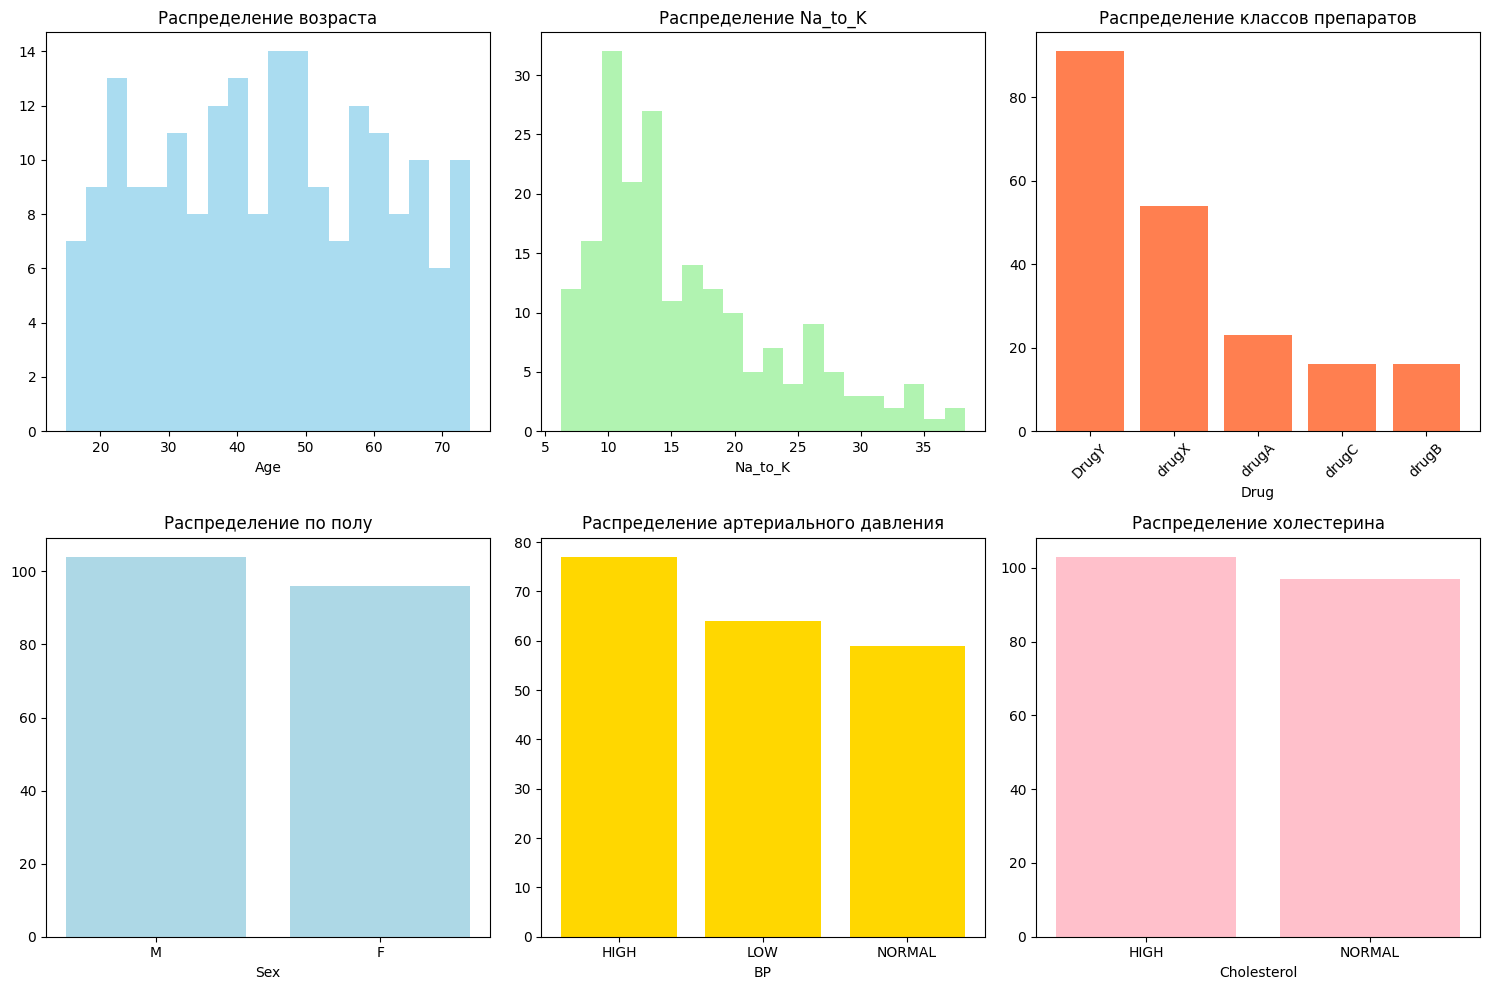

In [9]:
# Визуализация распределений
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Распределение возраста
axes[0, 0].hist(df['Age'], bins=20, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Распределение возраста')
axes[0, 0].set_xlabel('Age')

# Распределение пола
sex_counts = df['Sex'].value_counts()
axes[1, 0].bar(sex_counts.index, sex_counts.values, color='lightblue')
axes[1, 0].set_title('Распределение по полу')
axes[1, 0].set_xlabel('Sex')

# Распределение BP
bp_counts = df['BP'].value_counts()
axes[1, 1].bar(bp_counts.index, bp_counts.values, color='gold')
axes[1, 1].set_title('Распределение артериального давления')
axes[1, 1].set_xlabel('BP')

# Распределение холестерина
chol_counts = df['Cholesterol'].value_counts()
axes[1, 2].bar(chol_counts.index, chol_counts.values, color='pink')
axes[1, 2].set_title('Распределение холестерина')
axes[1, 2].set_xlabel('Cholesterol')

# Распределение Na_to_K
axes[0, 1].hist(df['Na_to_K'], bins=20, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Распределение Na_to_K')
axes[0, 1].set_xlabel('Na_to_K')

# Распределение классов
drug_counts = df['Drug'].value_counts()
axes[0, 2].bar(drug_counts.index, drug_counts.values, color='coral')
axes[0, 2].set_title('Распределение классов препаратов')
axes[0, 2].set_xlabel('Drug')
axes[0, 2].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()


1. Распределение возраста - не нормальное, равномерное, можно рассмотреть дискретизацию возраста на группы
2. Распределение Na_to_K - сильно смещенное впрао, можно использовать логарифмическое преобразование

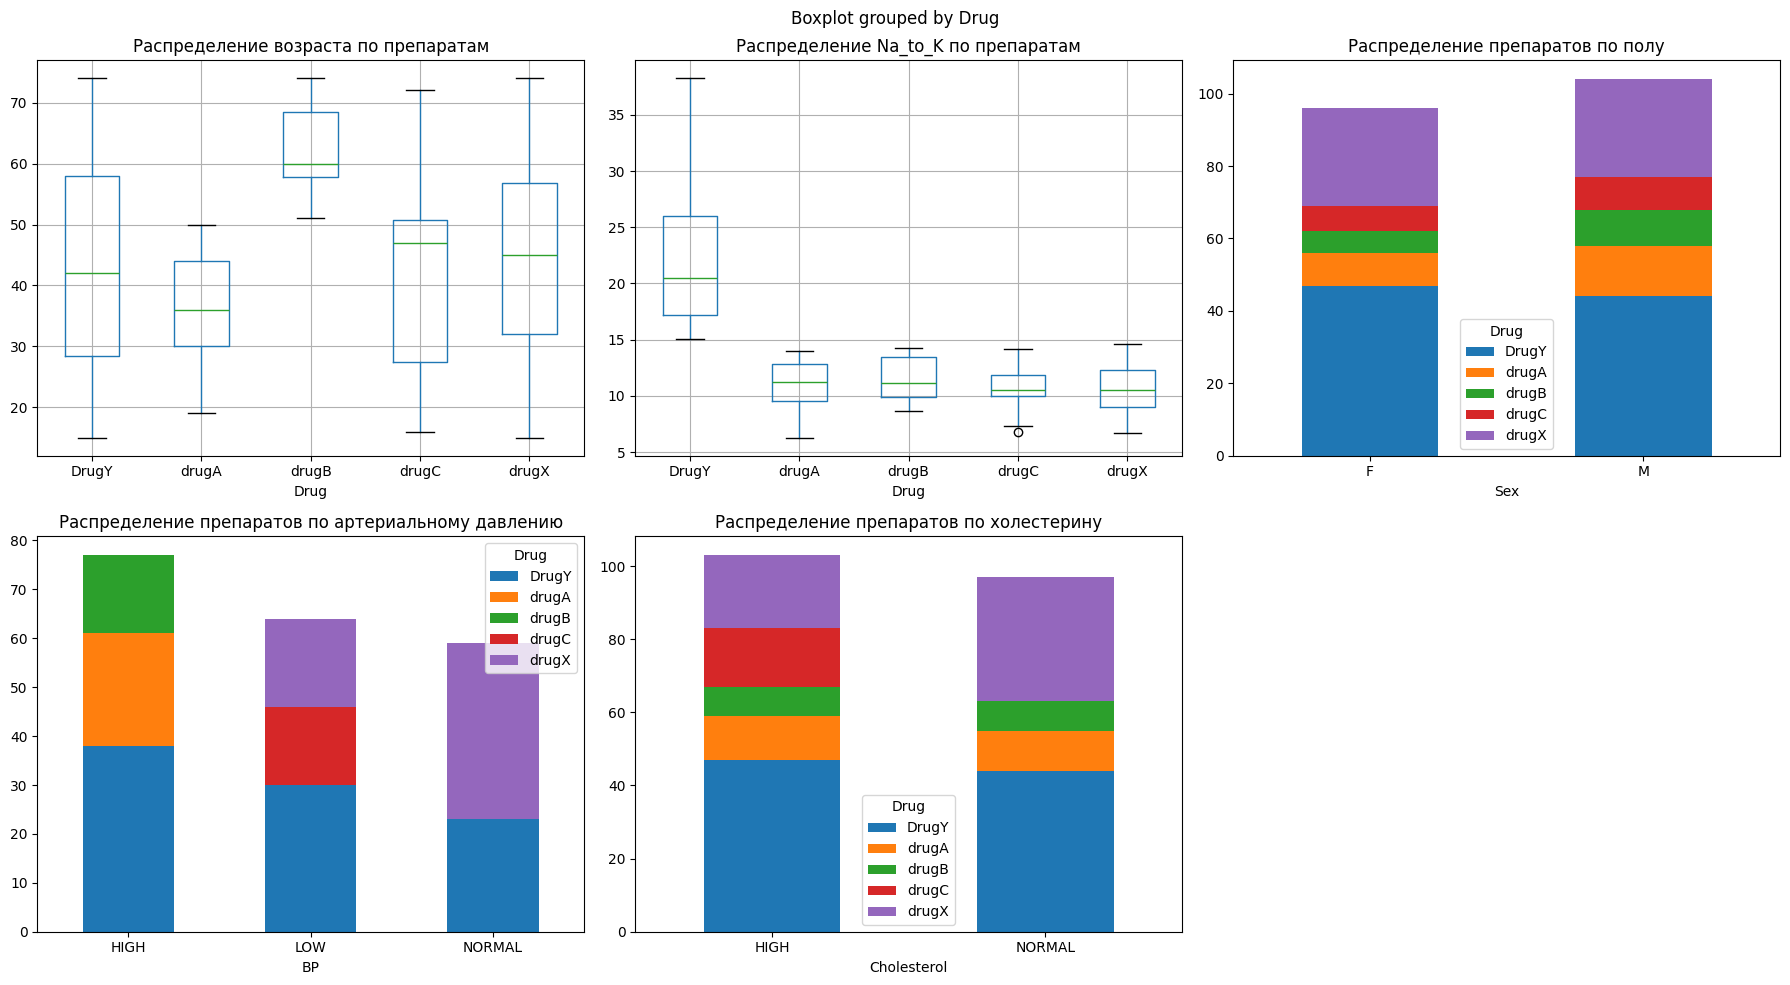

In [10]:
# Анализ связи между признаками и целевой переменной
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Числовые признаки - boxplot'ы
# Возраст по препаратам
df.boxplot(column='Age', by='Drug', ax=axes[0, 0])
axes[0, 0].set_title('Распределение возраста по препаратам')
axes[0, 0].set_xlabel('Drug')

# Na_to_K по препаратам
df.boxplot(column='Na_to_K', by='Drug', ax=axes[0, 1])
axes[0, 1].set_title('Распределение Na_to_K по препаратам')
axes[0, 1].set_xlabel('Drug')

# Категориальные признаки - crosstab графики
# Пол vs Препарат
sex_drug = pd.crosstab(df['Sex'], df['Drug'])
sex_drug.plot(kind='bar', ax=axes[0, 2], stacked=True)
axes[0, 2].set_title('Распределение препаратов по полу')
axes[0, 2].set_xlabel('Sex')
axes[0, 2].tick_params(axis='x', rotation=0)

# BP vs Препарат
bp_drug = pd.crosstab(df['BP'], df['Drug'])
bp_drug.plot(kind='bar', ax=axes[1, 0], stacked=True)
axes[1, 0].set_title('Распределение препаратов по артериальному давлению')
axes[1, 0].set_xlabel('BP')
axes[1, 0].tick_params(axis='x', rotation=0)

# Холестерин vs Препарат (был пропущен!)
cholesterol_drug = pd.crosstab(df['Cholesterol'], df['Drug'])
cholesterol_drug.plot(kind='bar', ax=axes[1, 1], stacked=True)
axes[1, 1].set_title('Распределение препаратов по холестерину')
axes[1, 1].set_xlabel('Cholesterol')
axes[1, 1].tick_params(axis='x', rotation=0)

# Удаляем пустой subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

У возраста хорошая дискриминативная способность, сильный предиктор для типа препарата, в отличии от Na_to_K

По полу почти одинаковое распределение - слабый предиктор

Артериальное давление - для HIGH доминируют DrugY и drugA, для LOW - DrugY и DrugC, NORMAL - DrugX - хороший предиктор

Холестерин - для обоих значений доминирует DrugY, но плюс что для HIGH есть DrugC и для NORMAL DrugX встречается чаще

Уберем пол, так как признак имеет низкую информативность

In [11]:
df.drop(columns=['Sex'], inplace=True)

Применим логарифмическое преобразование для Na_to_K

In [12]:
df['Na_to_K_log'] = np.log(df['Na_to_K'])
df.drop(columns=['Na_to_K'], inplace=True)

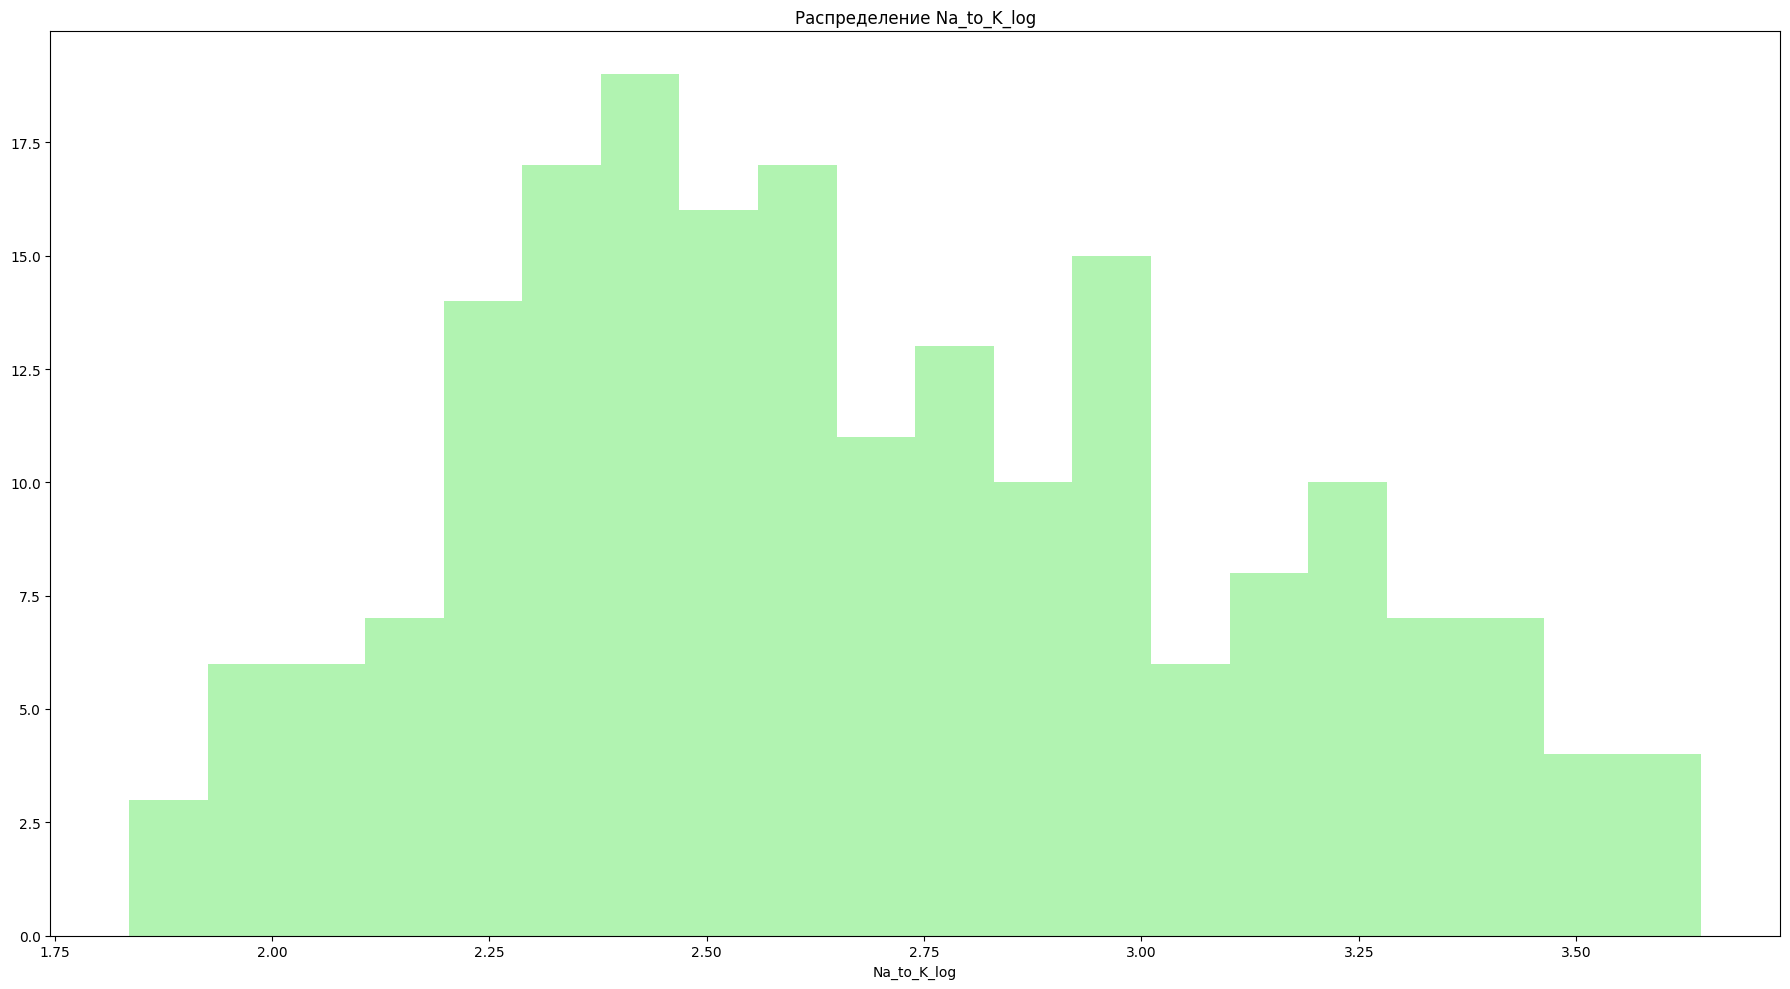

In [13]:
# Анализ связи между признаками и целевой переменной
fig, axes = plt.subplots(1, 1, figsize=(18, 10))

# Распределение Na_to_K_log
axes.hist(df['Na_to_K_log'], bins=20, alpha=0.7, color='lightgreen')
axes.set_title('Распределение Na_to_K_log')
axes.set_xlabel('Na_to_K_log')

plt.tight_layout()
plt.show()

Распределение стало уже ближе к нормальному

Можно было бы еще попробовать дискретизировать Age на группы

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Закодируем категориальные признаки

In [15]:
# Кодирование категориальных признаков
le_sex = LabelEncoder()
le_bp = LabelEncoder()
le_chol = LabelEncoder()
le_drug = LabelEncoder()

df_encoded = df.copy()
df_encoded['BP'] = le_bp.fit_transform(df['BP'])
df_encoded['Cholesterol'] = le_chol.fit_transform(df['Cholesterol'])
df_encoded['Drug'] = le_drug.fit_transform(df['Drug'])

# Разделение на признаки и целевую переменную
X = df_encoded[['Age', 'BP', 'Cholesterol', 'Na_to_K_log']]
y = df_encoded['Drug']


# 2. Реализовать наивный байесовский классификатор

In [16]:
import time
from collections import defaultdict
from scipy.stats import norm

In [17]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.feature_stats = {}  # Только для непрерывных признаков
        self.categorical_probs = {}  # Только для категориальных признаков
        self.classes = None
        
    def fit(self, X, y):
        """Обучение классификатора"""
        self.classes = np.unique(y)
        n_samples = len(y)
        
        # Вычисляем априорные вероятности классов
        for cls in self.classes:
            self.class_priors[cls] = np.sum(y == cls) / n_samples
        
        # Инициализируем словари
        self.feature_stats = defaultdict(dict)
        self.categorical_probs = defaultdict(dict)
        
        for cls in self.classes:
            cls_mask = (y == cls)
            cls_data = X[cls_mask]
            
            # Age и Na_to_K_log - непрерывные (Гауссовские)
            for feature in ['Age', 'Na_to_K_log']:
                mean = cls_data[feature].mean()
                std = cls_data[feature].std()
                self.feature_stats[cls][feature] = (mean, std)
            
            # BP и Cholesterol - категориальные (уже закодированы)
            for feature in ['BP', 'Cholesterol']:
                value_counts = cls_data[feature].value_counts()
                total_count = len(cls_data)
                probs = {}
                for value in X[feature].unique():
                    count = value_counts.get(value, 0)
                    probs[value] = (count + 1) / (total_count + len(X[feature].unique()))
                self.categorical_probs[cls][feature] = probs
    
    def _calculate_likelihood(self, x, cls):
        """Вычисляет правдоподобие для образца x и класса cls"""
        likelihood = 1.0
        
        # Непрерывные признаки
        for feature in ['Age', 'Na_to_K_log']:
            mean, std = self.feature_stats[cls][feature]
            if std == 0:
                std = 1e-6
            likelihood *= norm.pdf(x[feature], mean, std)
        
        # Категориальные признаки
        for feature in ['BP', 'Cholesterol']:
            prob = self.categorical_probs[cls][feature].get(x[feature], 1e-6)
            likelihood *= prob
        
        return likelihood
    
    def predict_proba(self, X):
        """Предсказывает вероятности классов"""
        probabilities = []
        
        for _, x in X.iterrows():
            class_probs = {}
            
            for cls in self.classes:
                likelihood = self._calculate_likelihood(x, cls)
                class_probs[cls] = likelihood * self.class_priors[cls]
            
            # Нормализация
            total_prob = sum(class_probs.values())
            if total_prob > 0:
                for cls in class_probs:
                    class_probs[cls] /= total_prob
            else:
                for cls in class_probs:
                    class_probs[cls] = 1.0 / len(self.classes)
            
            probabilities.append([class_probs[cls] for cls in sorted(self.classes)])
        
        return np.array(probabilities)
    
    def predict(self, X):
        """Предсказывает классы"""
        probabilities = self.predict_proba(X)
        return np.array([self.classes[np.argmax(prob)] for prob in probabilities])

# 3. Обучить модель на выбранном датасете
# 5. Замерить время обучения модели

In [18]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

# Обучаем нашу модель
nb_classifier = NaiveBayesClassifier()

start_time = time.time()
nb_classifier.fit(X_train, y_train)
custom_train_time = time.time() - start_time

print(f"\nВремя обучения собственной модели: {custom_train_time:.4f} секунд")

# Делаем предсказания
y_pred = nb_classifier.predict(X_test)
y_pred_proba = nb_classifier.predict_proba(X_test)

Размер обучающей выборки: (160, 4)
Размер тестовой выборки: (40, 4)

Время обучения собственной модели: 0.0090 секунд


# 4. Оценить качество модели с использованием кросс-валидации

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Точность по фолдам: [1.    0.975 0.95  0.95  1.   ]
Средняя точность: 0.9750 ± 0.0224

Точность на тестовой выборке: 0.9750

Отчет о классификации
              precision    recall  f1-score   support

     Class_0       0.95      1.00      0.97        18
     Class_1       1.00      1.00      1.00         5
     Class_2       1.00      1.00      1.00         3
     Class_3       1.00      1.00      1.00         3
     Class_4       1.00      0.91      0.95        11

    accuracy                           0.97        40
   macro avg       0.99      0.98      0.99        40
weighted avg       0.98      0.97      0.97        40


Матрица ошибок
[[18  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  3  0  0]
 [ 0  0  0  3  0]
 [ 1  0  0  0 10]]


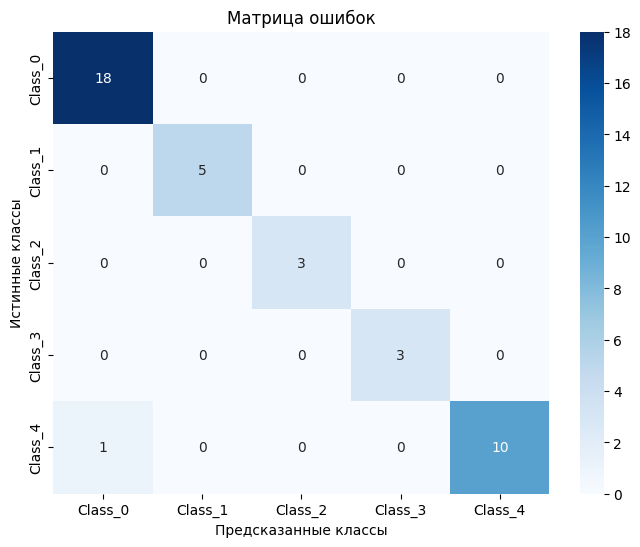

In [20]:
# Функция для кросс-валидации классификатора
def cross_validate_custom_nb(X, y, cv_folds=5):
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
        
        nb_cv = NaiveBayesClassifier()
        nb_cv.fit(X_train_cv, y_train_cv)
        y_pred_cv = nb_cv.predict(X_val_cv)
        
        score = accuracy_score(y_val_cv, y_pred_cv)
        scores.append(score)
    
    return np.array(scores)

cv_scores = cross_validate_custom_nb(X, y, cv_folds=5)

print(f"Точность по фолдам: {cv_scores}")
print(f"Средняя точность: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Оценка на тестовых данных
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nТочность на тестовой выборке: {test_accuracy:.4f}")

# Детальный отчет о классификации
print("\nОтчет о классификации")
target_names = [f"Class_{i}" for i in sorted(y.unique())]
print(classification_report(y_test, y_pred, target_names=target_names))

# Матрица ошибок
print("\nМатрица ошибок")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Матрица ошибок')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')
plt.show()

# 6. Сравнить результаты с эталонной реализацией из библиотеки scikit-learn


1. Точность:
Собственная реализация (тест): 0.9750
Scikit-learn (тест): 0.8500

2. Время обучения:
Собственная реализация: 0.0090 секунд
Scikit-learn: 0.0020 секунд
Разница: 0.0070 секунд


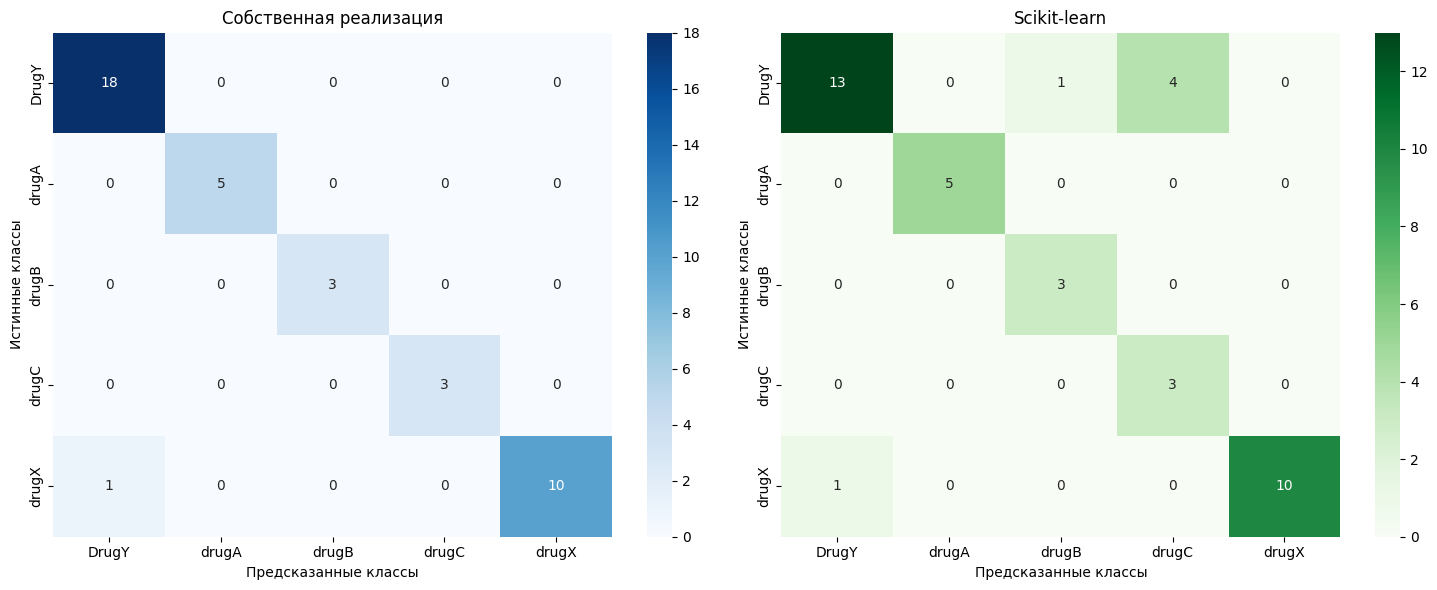


3. Детальное сравнение:

Собственная реализация
              precision    recall  f1-score   support

       DrugY       0.95      1.00      0.97        18
       drugA       1.00      1.00      1.00         5
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         3
       drugX       1.00      0.91      0.95        11

    accuracy                           0.97        40
   macro avg       0.99      0.98      0.99        40
weighted avg       0.98      0.97      0.97        40


Scikit-learn
              precision    recall  f1-score   support

       DrugY       0.93      0.72      0.81        18
       drugA       1.00      1.00      1.00         5
       drugB       0.75      1.00      0.86         3
       drugC       0.43      1.00      0.60         3
       drugX       1.00      0.91      0.95        11

    accuracy                           0.85        40
   macro avg       0.82      0.93      0.84        40
weighted avg  

In [21]:
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Обучение sklearn модели
sklearn_nb = GaussianNB()

start_time = time.time()
sklearn_nb.fit(X_train, y_train)
sklearn_train_time = time.time() - start_time

# Предсказания sklearn модели
sklearn_pred = sklearn_nb.predict(X_test)
sklearn_accuracy = accuracy_score(y_test, sklearn_pred)

# Кросс-валидация для sklearn
sklearn_cv_scores = cross_val_score(sklearn_nb, X, y, cv=5, scoring='accuracy')

# Сравнение результатов
print("\n1. Точность:")
print(f"Собственная реализация (тест): {test_accuracy:.4f}")
print(f"Scikit-learn (тест): {sklearn_accuracy:.4f}")

print("\n2. Время обучения:")
print(f"Собственная реализация: {custom_train_time:.4f} секунд")
print(f"Scikit-learn: {sklearn_train_time:.4f} секунд")
print(f"Разница: {abs(custom_train_time - sklearn_train_time):.4f} секунд")

# Получаем названия классов для матрицы ошибок
target_names = le_drug.inverse_transform(sorted(nb_classifier.classes))

# Матрица ошибок
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
cm_custom = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Собственная реализация')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')

plt.subplot(1, 2, 2)
cm_sklearn = confusion_matrix(y_test, sklearn_pred)
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Greens', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Scikit-learn')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')

plt.tight_layout()
plt.show()

print("\n3. Детальное сравнение:")
print("\nСобственная реализация")
print(classification_report(y_test, y_pred, target_names=target_names))

print("\nScikit-learn")
print(classification_report(y_test, sklearn_pred, target_names=target_names))

Отчет приложен в README.md